In [1]:
%run 'Functions.ipynb'

In [2]:
def terms_by_day(terms, start='1900-01-01', end='2020-01-01'):
    all_terms = Search(index='hep-analysis')[0:0] \
        .filter('range', earliest_date={'gte': start, 'lte': end})
    all_terms.aggs.bucket(
        'group_by_date', 
        'date_histogram', 
        field='earliest_date', 
        interval='day',
        format='date_optional_time'
    )

    given_terms = all_terms.query('match_phrase', **{'abstracts.value': terms})
    x, y = unzip(given_terms.execute().aggregations.group_by_date.buckets)
 
    if not len(y):
        return [], []
    
    total_x, total_y = unzip(all_terms.execute().aggregations.group_by_date.buckets)
    
    start = np.where(total_x == min(x))[0][0]
    end = np.where(total_x == max(x))[0][0]
    total_y = total_y[start:end+1]
        
    with np.errstate(divide='ignore', invalid='ignore'):
        normed_y = np.divide(y, total_y)
        normed_y[~ np.isfinite(normed_y)] = 0
        return x, normed_y

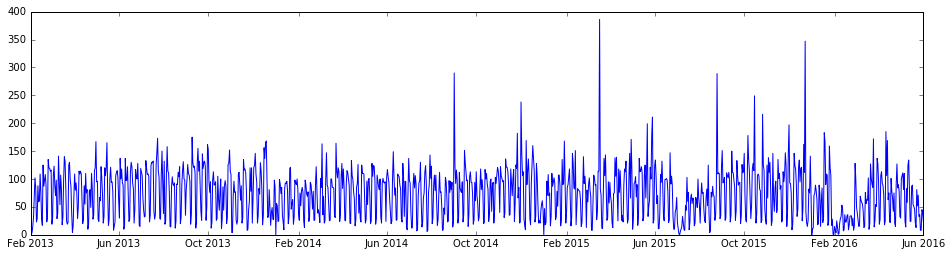

In [3]:
def all(start='1900-01-01', end='2020-01-01'):
    q = Search(index='hep-analysis')[0:0] \
    .filter('range', earliest_date={'gte': start, 'lt': end})
    q.aggs.bucket(
        'group_by_date', 
        'date_histogram', 
        field='earliest_date', 
        interval='day',
        format='date_optional_time'
    )
    return unzip(q.execute().aggregations.group_by_date.buckets)
x, y = all()
plt.plot(x, y)

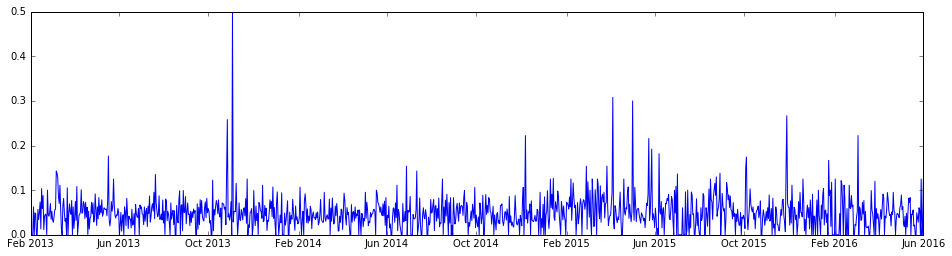

In [4]:
x, y = terms_by_day('gamma gamma')
plt.plot(x, y)

In [5]:
def repeat_sides(num, arr):
    arr = np.array(arr)
    left = np.ones(num) * arr[0]
    right = np.ones(num) * arr[-1]
    return np.append(left, np.append(arr, right))

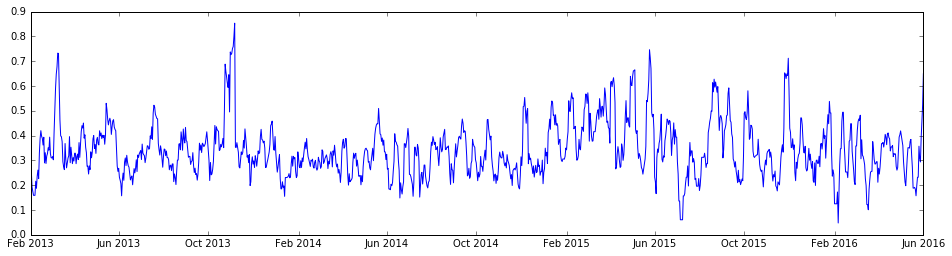

In [6]:
ay = sp.signal.convolve(repeat_sides(3, y), [1, 1, 1, 1, 1, 1, 1], mode='valid')
plt.plot(x, ay)

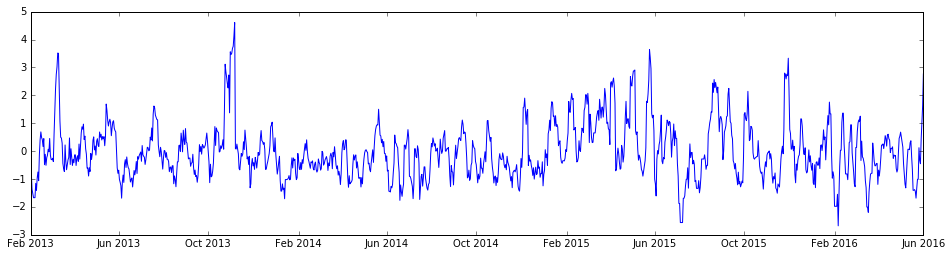

In [7]:
sy = sp.stats.zscore(ay)
plt.plot(x, sy)

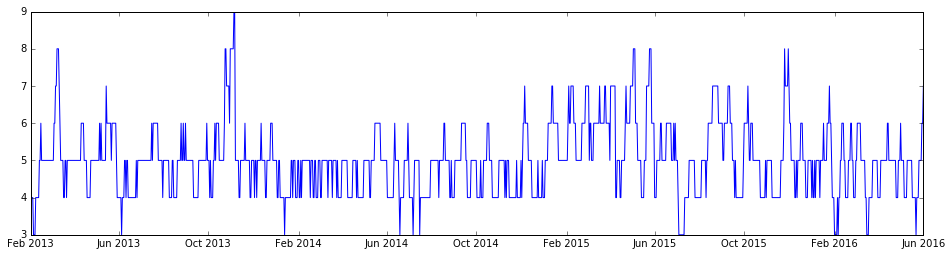

In [8]:
dy = np.digitize(sy, np.linspace(-5, 5, 10))
plt.plot(x, dy)

In [9]:
raw = fold_vectors(term_vectors(interval_ids('2015-01-01', days=31), 'abstracts.value'))

In [10]:
selected = {}
for k, v in sorted(raw.items()):
    if v['doc_freq'] >= 5:
        selected[k] = v

In [11]:
terms = sorted(selected.items(), key=lambda x: -x[1]['doc_freq'])

In [12]:
len(terms)

5805

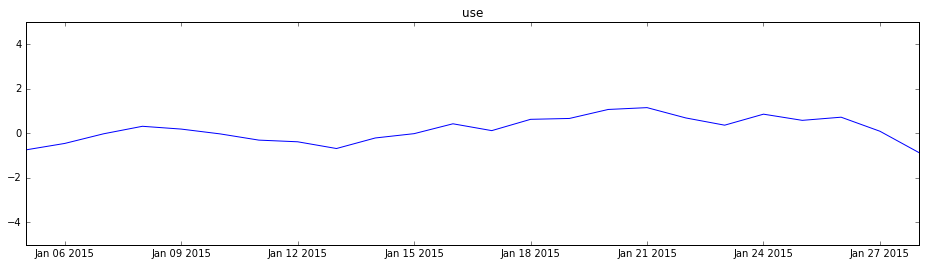

In [13]:
marked = []
unmarked = []

for term, _ in terms:

    x, y = terms_by_day(term, start='2015-01-01', end='2015-01-31')
    tx, ty = terms_by_day(term)
    
    if not len(y):
        continue
    
    ay = sp.signal.convolve(y, [1, 1, 1, 1, 1, 1, 1], mode='valid')
    aty = sp.signal.convolve(ty, [1, 1, 1, 1, 1, 1, 1], mode='valid')

    x = x[3:-3]
    tx = tx[3:-3]

    sy = (ay - np.mean(aty)) / np.std(aty)
    sty = (aty - np.mean(aty)) / np.std(aty)

    plt.gca().cla()

    plt.title(term)
    plt.ylim(-5, 5)
    plt.plot(x, sy)
    #plt.plot(tx, sty)
    
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf()) 
    
    command = input()
    if command == 'q':
        break
    elif command == 'a': # add mark
        marked.append(term)
    elif command == 'd': # delete mark
        unmarked.append(term)
        
IPython.display.clear_output()

In [14]:
higher = []
lower = []

for term, _ in terms:

    x, y = terms_by_day(term, start='2015-01-01', end='2015-01-31')
    tx, ty = terms_by_day(term)
    
    if not len(y):
        continue
    
    ay = y
    aty = ty
    ay = sp.signal.convolve(ay, [1, -1], mode='valid')
    ay = sp.signal.convolve(ay, [1, 1, 1, 1, 1, 1, 1], mode='valid')
    aty = sp.signal.convolve(aty, [1, -1], mode='valid')
    aty = sp.signal.convolve(aty, [1, 1, 1, 1, 1, 1, 1], mode='valid')

    x = x[4:-4]
    tx = tx[4:-4]
    
    sy = (ay - np.mean(aty)) / np.std(aty)
    sty = (aty - np.mean(aty)) / np.std(aty)
    
    if sy[np.argmax(sy)] >= 4:
        plt.plot(sy)
        higher.append(term)
    else:
        lower.append(term)

KeyboardInterrupt: 

In [ ]:
for term, _ in terms:

    x, y = terms_by_day(term, start='2015-01-01', end='2015-01-31')
    tx, ty = terms_by_day(term)
    
    if not len(y):
        continue

In [ ]:
higher

In [15]:
mapped = []

for term, _ in terms:

    x, y = terms_by_day(term, start='2015-01-01', end='2015-01-31')
    tx, ty = terms_by_day(term)
    
    if not len(y) or len(ty) < 7:
        continue
    
    before = x[0].day - 1
    after = 31 - x[-1].day
    y = np.append(np.zeros(before), y)
    y = np.append(y, np.zeros(after))
    
    ay = sp.signal.convolve(y, [1, 1, 1, 1, 1, 1, 1], mode='valid')
    aty = sp.signal.convolve(ty, [1, 1, 1, 1, 1, 1, 1], mode='valid')

    tx = tx[3:-3]

    sy = (ay - np.mean(aty)) / np.std(aty)
    dy = np.digitize(sy, np.linspace(-5, 5, 10))
    
    ly = [chr(97 + n) for n in dy]
    
    mapped.append((term, dy))

In [16]:
ref = 5 * np.ones_like(mapped[0][1])

In [17]:
len(mapped)

5788

In [18]:
from sklearn import metrics

In [19]:
v1 = [[1, 2, 4]]
v2 = [[1, 1, 3]]

In [20]:
metrics.pairwise_distances(v1, v2, metric='manhattan')

array([[ 2.]])

In [22]:
scored = [metrics.pairwise_distances([e], [ref], metric='manhattan')[0] for t, e in mapped]

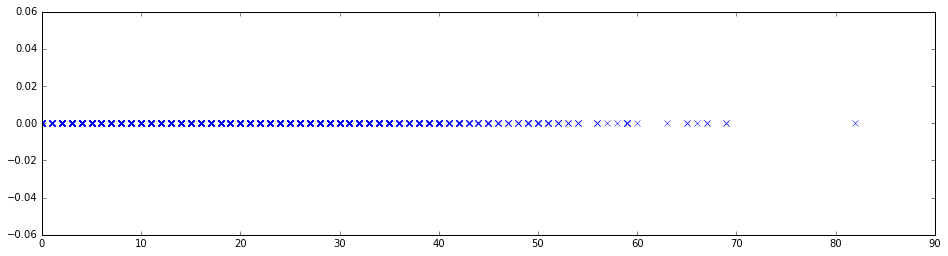

In [23]:
plt.plot(scored, np.zeros(len(scored)), 'x')

In [24]:
len(scored)

5788

In [25]:
from sklearn.cluster import KMeans

In [53]:
X = np.array([e for _, e in mapped])
X

array([[3, 4, 5, ..., 6, 5, 4],
       [3, 5, 5, ..., 4, 4, 5],
       [4, 5, 5, ..., 6, 6, 6],
       ..., 
       [7, 7, 7, ..., 5, 5, 5],
       [5, 5, 5, ..., 4, 4, 4],
       [5, 5, 5, ..., 4, 4, 4]])

In [27]:
km = KMeans(n_clusters=5)
y_pred = km.fit_predict(X)

In [28]:
X[y_pred]

array([[3, 5, 5, ..., 4, 4, 5],
       [3, 5, 5, ..., 4, 4, 5],
       [3, 5, 5, ..., 4, 4, 5],
       ..., 
       [4, 5, 5, ..., 6, 6, 6],
       [4, 5, 6, ..., 5, 5, 5],
       [4, 5, 6, ..., 5, 5, 5]])

In [29]:
len(y_pred)

5788

In [30]:
from sklearn.decomposition import PCA

In [31]:
p = PCA(n_components=3).fit_transform(X)

In [32]:
from mpl_toolkits.mplot3d import Axes3D

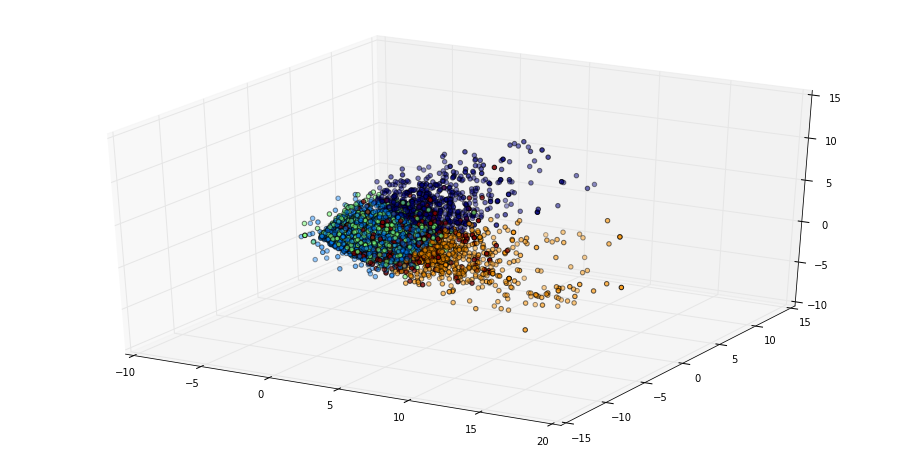

In [39]:
ax = plt.subplot(projection='3d')
ax.scatter(p[:, 0], p[:, 1], p[:, 2], c=y_pred)

In [35]:
%matplotlib inline 
# notebook
pylab.rcParams['figure.figsize'] = (16, 8)

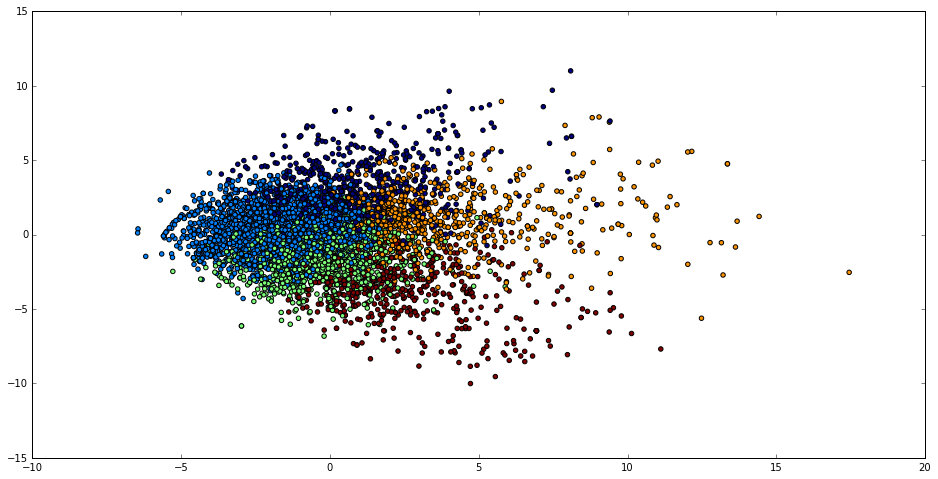

In [40]:
plt.scatter(p[:, 0], p[:, 1], c=y_pred)

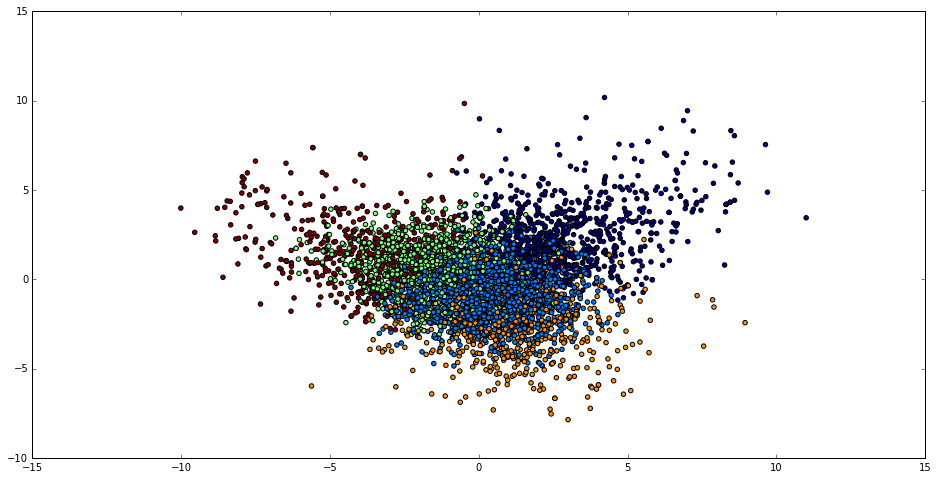

In [41]:
plt.scatter(p[:, 1], p[:, 2], c=y_pred)

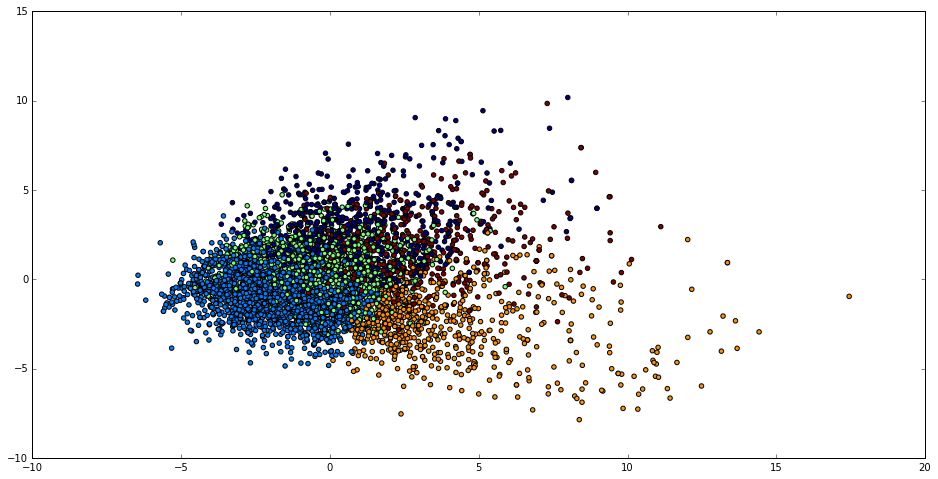

In [42]:
plt.scatter(p[:, 0], p[:, 2], c=y_pred)

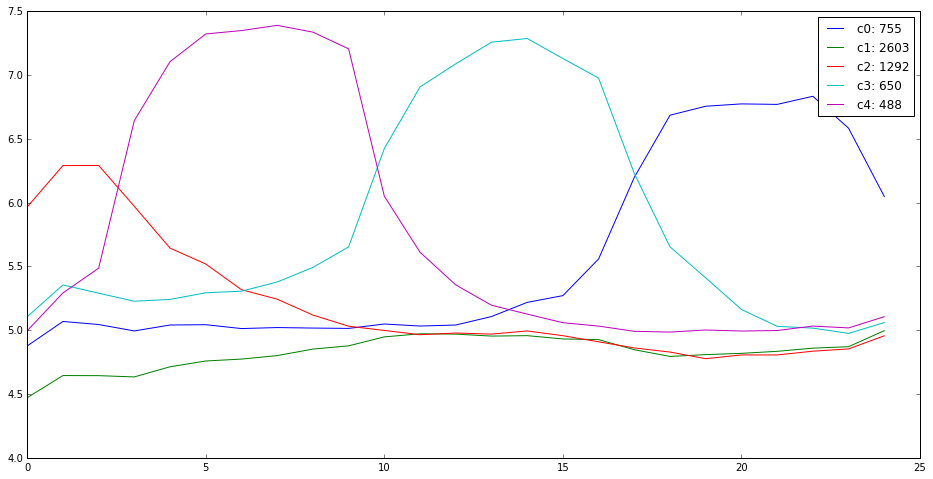

In [43]:
for i, center in enumerate(km.cluster_centers_):
    plt.plot(center, label='c%d: %d' % (i, np.count_nonzero(y_pred == i)))
plt.legend()

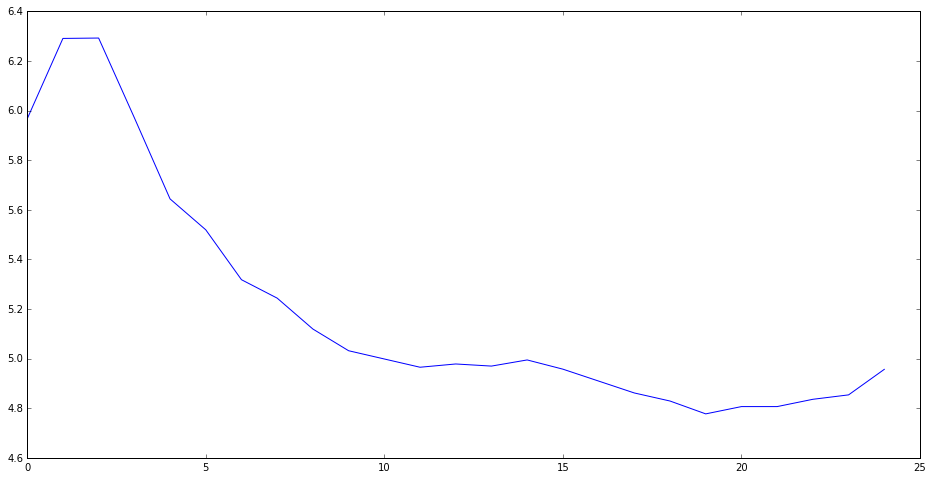

In [44]:
plt.plot(km.cluster_centers_[2])

In [45]:
mapped[:5]

[('use',
  array([3, 4, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6,
         5, 4])),
 ('model',
  array([3, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 4, 4, 4, 4, 4, 4,
         4, 5])),
 ('result',
  array([4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6,
         6, 6])),
 ('can',
  array([4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 5, 5, 5, 5, 4, 4, 4, 4, 5, 5,
         5, 5])),
 ('energy',
  array([4, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6,
         5, 5]))]

In [46]:
label = np.array([t for t, s in mapped])

In [47]:
s = []

for i, cluster in enumerate(y_pred):
    
    if cluster == 2:
        stats = terms[i][1]
        print(mapped[i][0])
        s.append([stats['doc_total'], stats['doc_freq'], stats['doc_freq']])

s = np.array(s)

can
theory
non
scale
case
state
provide
low
property
general
light
symmetry
galaxy
terms
physics
solution
however
background
like
evolution
constant
emission
gravitation
require
power
introduce
numerical
detect
group
star
signal
component
theoretical
various
detection
considered
many
observation
sample
second
massive
flux
expect
technique
independent
us
local
conditions
analytic
thus
break
formation
sim
optical
field theory
explore
improve
review
perturbation
redshift
line
gas
generalize
addition
comparison
cluster
resolution
close
medium
statistic
call
leads
reduce
much
jet
distance
classical
einstein
alpha
carry
beyond
frequency
good
radius
geometry
reproduce
object
analyse
understanding
ground
curve
sensitivity
excite
multi
violate
critical
along
fluctuate
yield
formalism
global
imply
complete
exact
allow us
scalar field
accretion
binary
per
sensitive
novel
occur
dominate
pm
relative
moreover
spherical
error
characteristic
performance
implication
entropy
generation
emit
large scale


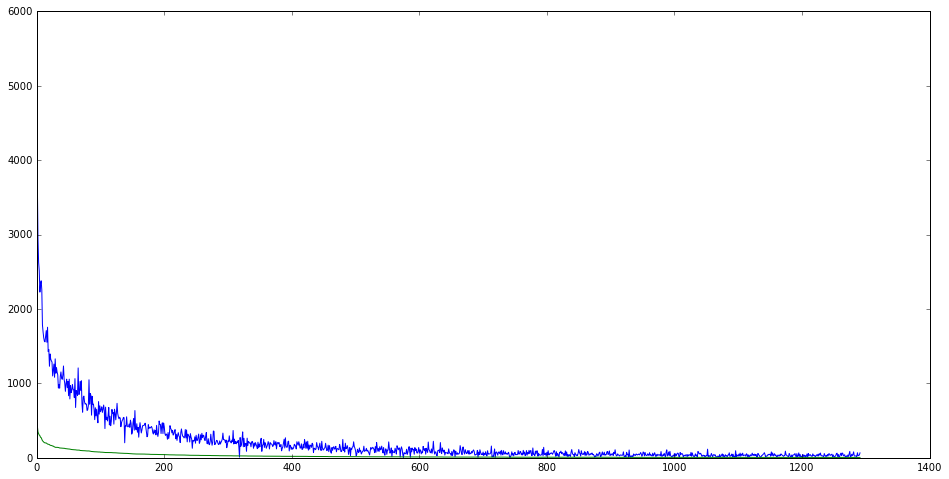

In [48]:
plt.plot(s[:, 0])
plt.plot(s[:, 1])

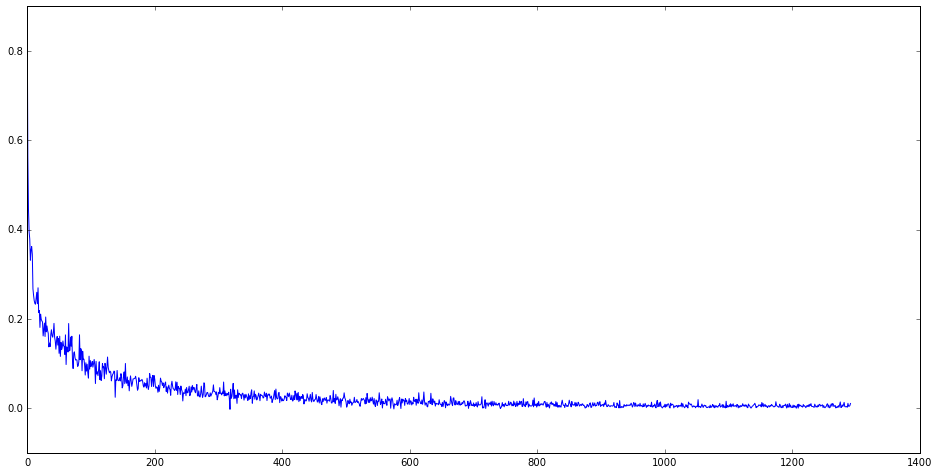

In [49]:
plt.plot(s[:, 0] / np.max(s[:, 0]) - s[:, 1] / np.max(s[:, 0]))

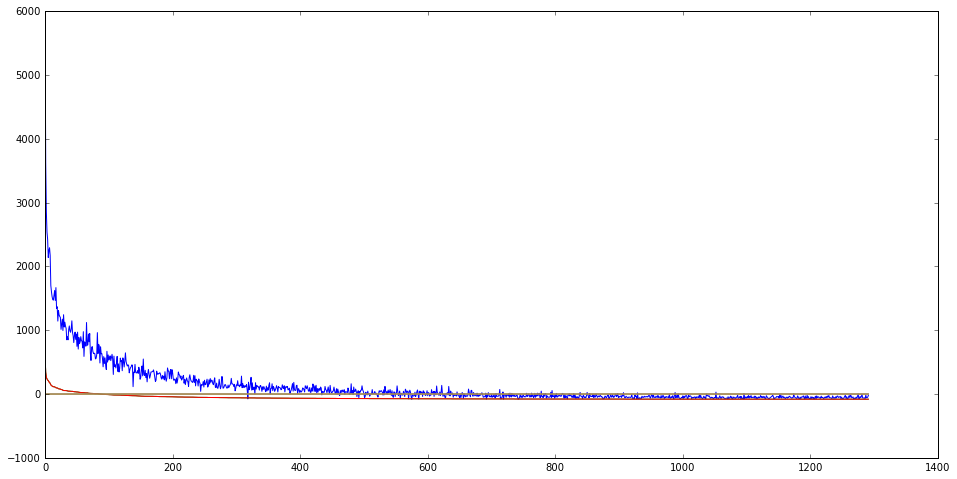

In [50]:
plt.plot(s - np.mean(s))
plt.plot(np.zeros_like(s))